In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h3pandas as h3pd

listings_file = 'buenos_aires.csv.gz'
reviews_file = 'reviews_buenos_aires.csv'
output_file = 'buenos_aires_hex_listings.gpkg'
hex_scale = 10

In [2]:
# load listings
listings = pd.read_csv(listings_file, usecols=['id', 'latitude', 'longitude'])
listings.rename(columns={'latitude': 'lat', 'longitude': 'lng'}, inplace=True)
print(listings.shape)

listings.head(2)

(26204, 3)


,id,lat,lng
0,11508,-34.58184,-58.42415
1,14222,-34.58617,-58.41036


In [3]:
# load reviews
rev = pd.read_csv(reviews_file)
rev['year'] = pd.to_datetime(rev.date).dt.year
rev['year'] = 'reviews_' + rev['year'].astype(str)

cols = list(rev.year.unique())
cols.sort()

rev.head()

,listing_id,date,year
0,11508,2012-07-02,reviews_2012
1,11508,2012-12-26,reviews_2012
2,11508,2013-01-05,reviews_2013
3,11508,2013-07-28,reviews_2013
4,11508,2013-12-22,reviews_2013


In [4]:
# crosstab
rev_crosstab = pd.crosstab(rev.listing_id, rev.year).reset_index()
print(rev_crosstab.shape)

for col in cols:
    rev_crosstab[col] = np.where(rev_crosstab[col] >= 1, True, False)

rev_crosstab.head()

(21260, 15)


year,listing_id,reviews_2010,reviews_2011,reviews_2012,reviews_2013,reviews_2014,reviews_2015,reviews_2016,reviews_2017,reviews_2018,reviews_2019,reviews_2020,reviews_2021,reviews_2022,reviews_2023
0,11508,False,False,True,True,True,True,True,True,True,True,False,True,True,True
1,14222,False,False,True,True,True,True,True,True,True,True,True,True,True,True
2,16695,False,True,True,False,True,True,True,True,True,True,False,False,False,False
3,20062,True,True,True,True,True,True,True,True,True,True,True,True,True,True
4,24713,False,False,False,True,True,True,True,True,True,True,True,False,True,True


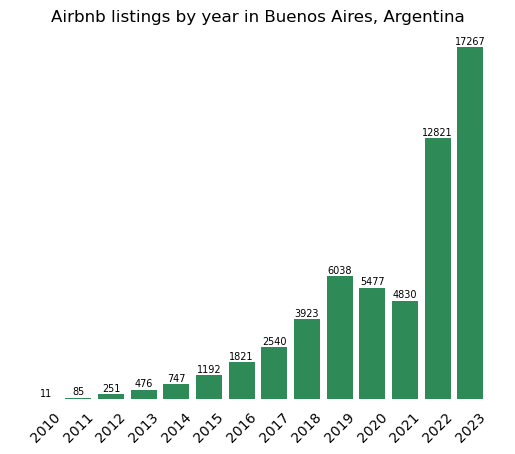

In [5]:
listings_acc = [sum(rev_crosstab[col]) for col in cols]
years = list(range(2010, 2024))

plt.bar(years, listings_acc, color='seagreen')
plt.title('Airbnb listings by year in Buenos Aires, Argentina')

# Add data labels above each bar
for year, nlistings in zip(years, listings_acc):
    plt.text(year, nlistings + 50, str(nlistings), ha='center', va='bottom', size=7)

# Remove all borders (top, right, left, bottom)
def remove_spines():
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
remove_spines()

# Remove left ticks and tick labels
ax = plt.gca()
ax.tick_params(axis='y', left=False, labelleft=False)
plt.tick_params(axis='x', bottom=False)
plt.xticks(years, rotation=45)

plt.show()

In [6]:
# This will save one chart per year in the charts folder
plt.ioff()

for year in years:
    plt.figure(figsize=(8, 6)) 
    plt.plot(years, listings_acc,  linestyle='-', linewidth=4, color='grey')

    for i in range(len(years)):
        if years[i] == year:
            color = '#cb4200'
            plt.plot(years[i], listings_acc[i], marker='o', markersize=10, linestyle='-', color=color)
            if years[i] == 2020:
                plt.text(year, listings_acc[i] - 1500, str('COVID'), ha='center', va='bottom', size=14, color=color)
        else:
            plt.plot(years[i], listings_acc[i], marker='o', markersize=10, linestyle='-', color='grey')

    plt.xlim(min(years)-1, max(years)+1)
    plt.ylim(min(listings_acc)-600, max(listings_acc)+600)
    ax = plt.gca()

    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    remove_spines()

    plt.savefig(f'charts/listings_bsas_{year}.png', transparent=True)

In [7]:
merge = listings.merge(rev_crosstab, left_on='id', right_on='listing_id', how='inner')
hex = merge.h3.geo_to_h3(hex_scale)
hex.head(2)

,id,lat,lng,listing_id,reviews_2010,reviews_2011,reviews_2012,reviews_2013,reviews_2014,reviews_2015,reviews_2016,reviews_2017,reviews_2018,reviews_2019,reviews_2020,reviews_2021,reviews_2022,reviews_2023
h3_10,,,,,,,,,,,,,,,,,,
8ac2e3118357fff,11508,-34.58184,-58.42415,11508,False,False,True,True,True,True,True,True,True,True,False,True,True,True
8ac2e3118477fff,14222,-34.58617,-58.41036,14222,False,False,True,True,True,True,True,True,True,True,True,True,True,True


In [8]:
def agg_hex_processing(df, column, scale):
    '''Process a grouped hex grid'''
    hex_scale = 'h3_' + str(scale).zfill(2)
    hex_group = df.loc[:, column].to_frame().groupby(hex_scale)\
        .sum().h3.h3_to_geo_boundary()
    hex_group.rename({column: 'reviews'}, axis=1, inplace=True)
    hex_group['year'] = int(column.replace('reviews_', ''))

    return hex_group

review_cols = [f'reviews_{year}' for year in years]
all_hex = [agg_hex_processing(hex, col, hex_scale) for col in review_cols]

In [9]:
# exports
all_hex_concat = pd.concat(all_hex).to_crs(3857)
all_hex_concat.to_file(output_file, driver='GPKG')